<a href="https://colab.research.google.com/github/HkgCory/Transfer-Learning/blob/main/transfer_learing_tf_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Extraction

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data



In [ ]:
# data link - https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

In [ ]:
# import zipfile

# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
# zip_ref.extractall()
# zip_ref.close()

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import os

In [ ]:
import os
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent/'):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}".')

There are 2 directories and 0 images in "10_food_classes_10_percent/".
There are 10 directories and 0 images in "10_food_classes_10_percent/train".
There are 0 directories and 75 images in "10_food_classes_10_percent/train/pizza".
There are 0 directories and 75 images in "10_food_classes_10_percent/train/steak".
There are 0 directories and 75 images in "10_food_classes_10_percent/train/chicken_wings".
There are 0 directories and 75 images in "10_food_classes_10_percent/train/chicken_curry".
There are 0 directories and 75 images in "10_food_classes_10_percent/train/sushi".
There are 0 directories and 75 images in "10_food_classes_10_percent/train/hamburger".
There are 0 directories and 75 images in "10_food_classes_10_percent/train/grilled_salmon".
There are 0 directories and 75 images in "10_food_classes_10_percent/train/fried_rice".
There are 0 directories and 75 images in "10_food_classes_10_percent/train/ramen".
There are 0 directories and 75 images in "10_food_classes_10_percent/tr

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Training Images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                         target_size=IMAGE_SHAPE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode='categorical')

print('Testing Images:')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Training Images:
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


In [ ]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f'Saving TensorBoard log files to: {log_dir}')
    return tensorboard_callback

In [ ]:
import tensorflow_hub as hub

model = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2")
embeddings = model(["The rain in Spain.", "falls",
                    "mainly", "In the plain!"])

print(embeddings.shape)  #(4,128)

(4, 128)


In [ ]:
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [ ]:
def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

    Args:
        model_url (str): A TensorFlow Hub feature extraction URL.
        num_classes (int): Number of output neurons in the output layer,
            should be equal to number of target classes, default 10.

    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor
        layer and Dense output layer with num_classes output neurons.
    """
    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False, # freeze the already learned patterns
                                             name='feature_extraction_layer',
                                             input_shape=IMAGE_SHAPE+(3,)) # 3 for color channels

    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation='softmax', name='output_layer')
    ])

    return model

In [ ]:
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
train_data_10_percent.num_classes

10

In [ ]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=int(0.25 * len(test_data)),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='resnet50v2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20230409-210206
Epoch 1/5
24/24 [==============================] - 27s 478ms/step - loss: 1.9772 - accuracy: 0.3493 - val_loss: 1.1878 - val_accuracy: 0.6316
Epoch 2/5
24/24 [==============================] - 9s 384ms/step - loss: 0.9158 - accuracy: 0.7160 - val_loss: 0.8377 - val_accuracy: 0.7352
Epoch 3/5
24/24 [==============================] - 9s 382ms/step - loss: 0.6323 - accuracy: 0.8240 - val_loss: 0.7505 - val_accuracy: 0.7599
Epoch 4/5
24/24 [==============================] - 9s 379ms/step - loss: 0.4845 - accuracy: 0.8667 - val_loss: 0.7197 - val_accuracy: 0.7730
Epoch 5/5
24/24 [==============================] - 10s 412ms/step - loss: 0.3922 - accuracy: 0.9067 - val_loss: 0.6450 - val_accuracy: 0.8010


In [ ]:
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('loss')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('accuracy')
    plt.xlabel('epochs')
    plt.legend()


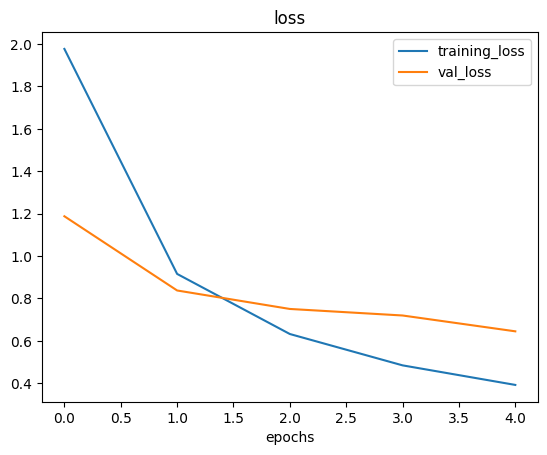

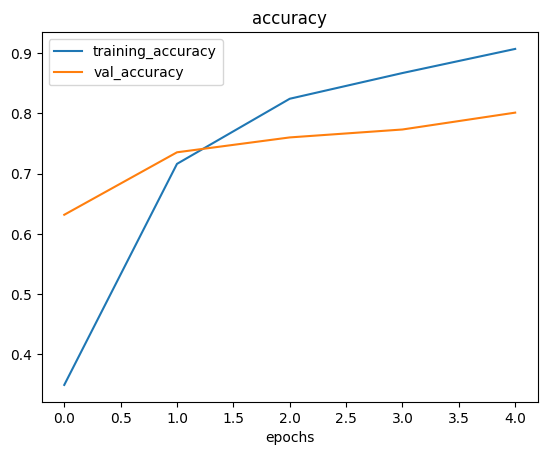

In [ ]:
plot_loss(resnet_history)

In [ ]:
efficientnet_model = create_model(model_url=efficientnet_url,
                                num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(loss='categorical_crossentropy',
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=int(0.25 * len(test_data)),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                     experiment_name='efficientnetb0')])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20230409-210322
Epoch 1/5
24/24 [==============================] - 22s 472ms/step - loss: 1.7665 - accuracy: 0.4907 - val_loss: 1.2482 - val_accuracy: 0.7467
Epoch 2/5
24/24 [==============================] - 7s 281ms/step - loss: 1.0237 - accuracy: 0.7733 - val_loss: 0.8139 - val_accuracy: 0.8438
Epoch 3/5
24/24 [==============================] - 9s 377ms/step - loss: 0.7444 - accuracy: 0.8213 - val_loss: 0.7046 - val_accuracy: 0.8355
Epoch 4/5
24/24 [==============================] - 10s 403ms/step - loss: 0.6031 - accuracy: 0.8560 - val_loss: 0.6073 - val_accuracy: 0.8553
Epoch 5/5
24/24 [==============================] - 8s 321ms/step - loss: 0.5116 - accuracy: 0.8813 - val_loss: 0.5614 - val_accuracy: 0.8668


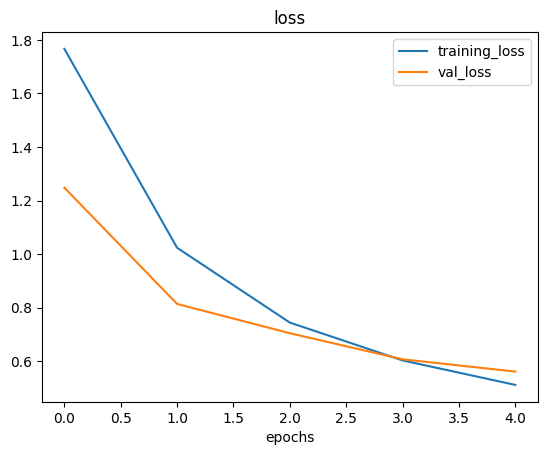

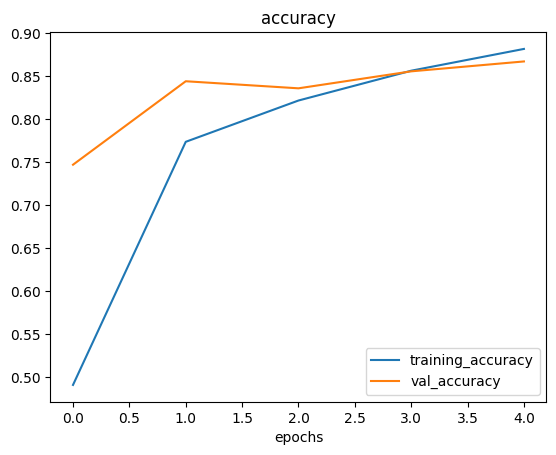

In [ ]:
plot_loss(efficientnet_history)

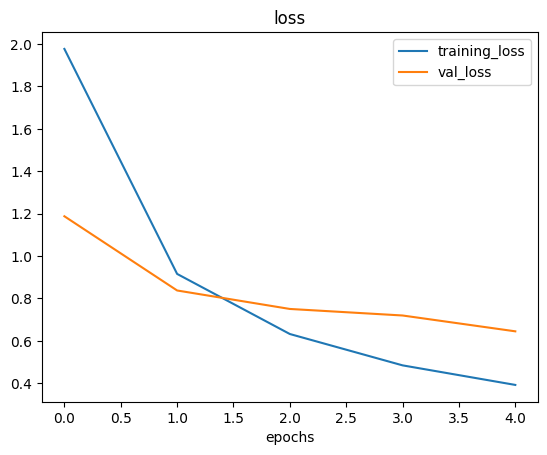

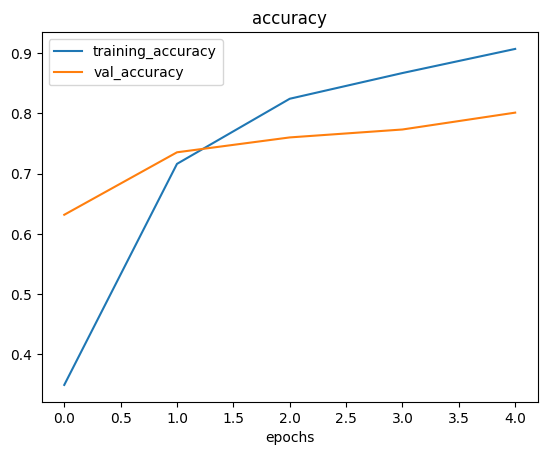

In [ ]:
plot_loss(resnet_history)

In [ ]:
efficientnet_model_test = create_model(model_url=efficientnet_url,
                                num_classes=train_data_10_percent.num_classes)

efficientnet_model_test.compile(loss='categorical_crossentropy',
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=['accuracy'])

efficientnet_history = efficientnet_model_test.fit(train_data_10_percent,
                                              epochs=10,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=int(0.25 * len(test_data)),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                     experiment_name='efficientnetb0')])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20230409-210441
Epoch 1/10
24/24 [==============================] - 21s 421ms/step - loss: 1.8871 - accuracy: 0.4280 - val_loss: 1.2911 - val_accuracy: 0.7286
Epoch 2/10
24/24 [==============================] - 8s 323ms/step - loss: 1.0787 - accuracy: 0.7760 - val_loss: 0.8843 - val_accuracy: 0.8010
Epoch 3/10
24/24 [==============================] - 8s 321ms/step - loss: 0.7631 - accuracy: 0.8387 - val_loss: 0.7029 - val_accuracy: 0.8355
Epoch 4/10
24/24 [==============================] - 9s 374ms/step - loss: 0.6142 - accuracy: 0.8667 - val_loss: 0.6707 - val_accuracy: 0.8520
Epoch 5/10
24/24 [==============================] - 7s 282ms/step - loss: 0.5169 - accuracy: 0.8920 - val_loss: 0.5894 - val_accuracy: 0.8520
Epoch 6/10
24/24 [==============================] - 9s 373ms/step - loss: 0.4509 - accuracy: 0.9040 - val_loss: 0.4920 - val_accuracy: 0.8750
Epoch 7/10
24/24 [==============================] - 7s 303ms/step - 

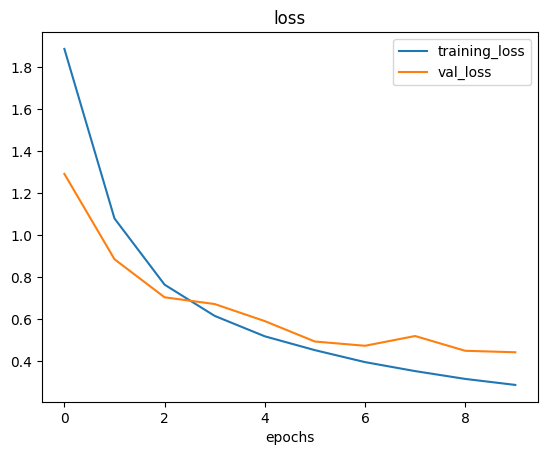

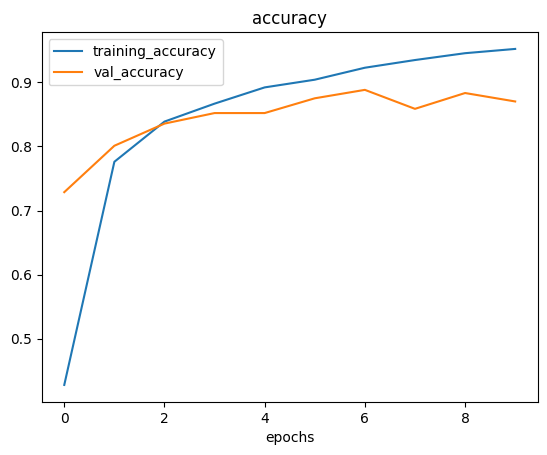

In [ ]:
plot_loss(efficientnet_history)

In [ ]:
len(efficientnet_model.layers[0].weights)

309

In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
    --name "EfficientNetB0 vs ResNet50V2" \
    --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
    --one_shot # exits the tensorboard dev uploader once upload has finished


2023-04-09 21:06:43.880001: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes



To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   MRQP-JTRQ

MRQP-JTRQ


New experiment created. View your TensorBoard at: https://tensorbo